<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/CROP_D1_CNN1_A3_70.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import keras
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.applications.resnet50 import preprocess_input

In [3]:
def preprocess_image(image_path):
    # Read grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize image to (224, 224)
    image = cv2.resize(image, (224, 224))
    # Convert grayscale to RGB by stacking the single channel
    image_rgb = np.stack((image,) * 3, axis=-1)
    # Preprocess image for ResNet50 model
    image_rgb = preprocess_input(image_rgb)
    return image_rgb

In [4]:
from google.colab import drive

drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/Dataset/Dataset2/crop_part1.zip'

Streaming output truncated to the last 5000 lines.
  inflating: crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104204327523.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170105164106036.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170105172720493.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170108224608753.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170109140259136.jpg.

In [5]:
# Define age ranges
age_ranges = [(1, 2), (3, 9), (10, 20), (21, 27), (28, 45), (46, 65), (66, 116)]

# Function to map age to range index
def age_to_range(age, age_ranges):
    for idx, (start, end) in enumerate(age_ranges):
        if start <= age <= end:
            return idx
    return None

In [6]:
def preprocess_labels(labels, num_classes):
    # One-hot encode labels
    labels = to_categorical(labels, num_classes=num_classes)
    return labels

In [11]:
# Load and preprocess the dataset
image_dir = '/content/crop_part1'
images=[]
image_paths = []
age_labels = []
age_groups = []
target_size = (224, 224)

for filename in os.listdir(image_dir):
  if filename.endswith(".jpg"):
    age = int(filename.split('_')[0])
    range_index = age_to_range(age, age_ranges)
    age_labels.append(range_index)

    image_path = os.path.join(image_dir, filename)
    image = preprocess_image(image_path)
    images.append(image)
    image_paths.append(image_path)

images = np.array(images)
age_groups = age_labels
age_labels = preprocess_labels(age_labels, len(age_ranges))

In [12]:
# Print shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {age_labels.shape}")

Images shape: (9780, 224, 224, 3)
Labels shape: (9780, 7)


In [13]:
def age_group_to_interval(group_index):
    if group_index < 0 or group_index >= len(age_ranges):
        return "Unknown"

    start, end = age_ranges[group_index]
    return f"{start}-{end}"

In [14]:
import pandas as pd
df = pd.DataFrame()
age_intervals = [age_group_to_interval(age) for age in age_groups]
df['images_path'],df['age'] = image_paths,age_intervals
df.head(10)

,images_path,age
0,/content/crop_part1/47_1_3_20170109133358794.j...,46-65
1,/content/crop_part1/1_0_0_20170110213202543.jp...,1-2
2,/content/crop_part1/1_0_2_20161219153318900.jp...,1-2
3,/content/crop_part1/1_1_4_20161221193742646.jp...,1-2
4,/content/crop_part1/14_0_0_20170103200600206.j...,10-20
5,/content/crop_part1/15_0_0_20170110225622776.j...,10-20
6,/content/crop_part1/2_1_3_20161219225500961.jp...,1-2
7,/content/crop_part1/28_1_0_20170104181556245.j...,28-45
8,/content/crop_part1/38_1_0_20170109002805707.j...,28-45
9,/content/crop_part1/1_0_2_20161219155759221.jp...,1-2


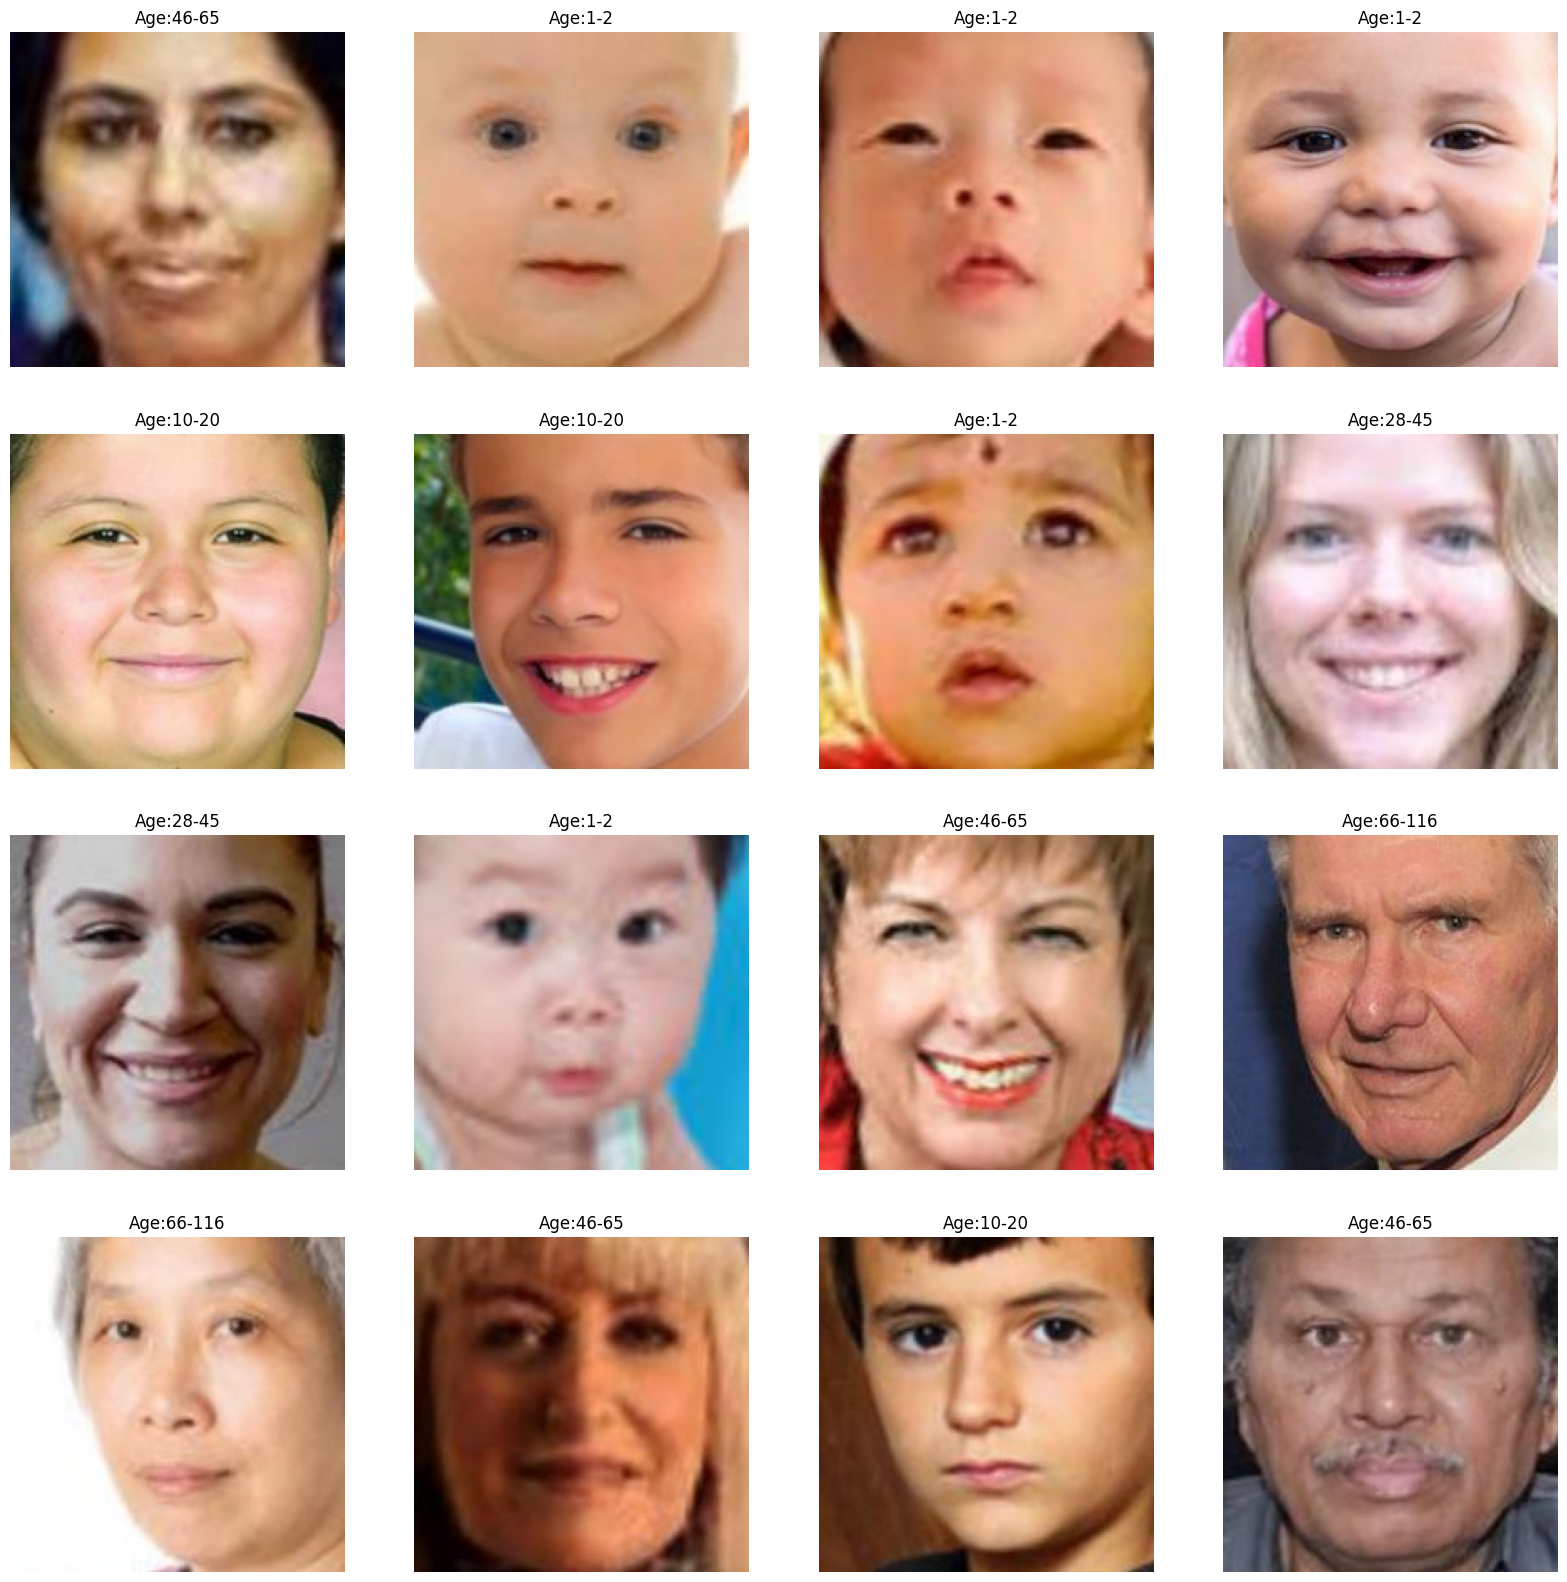

In [15]:
plt.figure(figsize=(20,20))
samples = df.iloc[0:16]

for index,sample,age in samples.itertuples():
  plt.subplot(4,4,index+1)
  img = load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Age:{age}')
  plt.imshow(img)

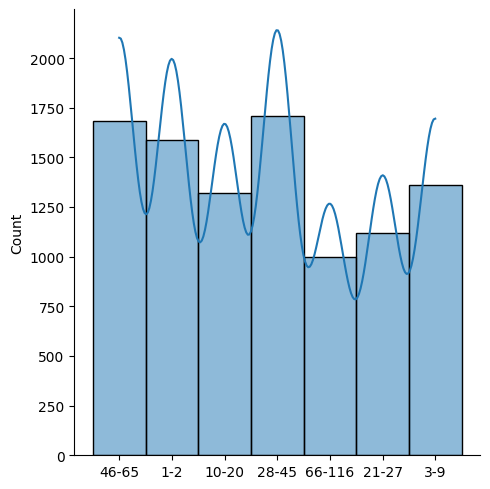

In [16]:
#age distribution
sns.displot(data=age_intervals,kde=True)

In [17]:
train_images, test_images, train_age_groups, test_age_groups = train_test_split(images, age_labels, test_size=0.2, random_state=42)


In [18]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(132, activation='relu')(x)
predictions = Dense(len(age_ranges), activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 1s 0us/step


In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dataset/Dataset2/model-weights/CROP_D1_CNN1_A3.h5',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,  # Only save the best model
    mode='max'  # Mode to determine best (maximizing validation accuracy)
)


In [22]:
model.fit(train_images, train_age_groups, validation_split=0.2, epochs=60, batch_size=32, callbacks=[model_checkpoint], shuffle=False)


Epoch 1/60
196/196 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9803
Epoch 1: val_accuracy did not improve from 0.64920
196/196 [==============================] - 36s 185ms/step - loss: 0.0564 - accuracy: 0.9803 - val_loss: 2.7880 - val_accuracy: 0.5361
Epoch 2/60
196/196 [==============================] - ETA: 0s - loss: 0.1249 - accuracy: 0.9551
Epoch 2: val_accuracy did not improve from 0.64920
196/196 [==============================] - 35s 177ms/step - loss: 0.1249 - accuracy: 0.9551 - val_loss: 1.6320 - val_accuracy: 0.5706
Epoch 3/60
196/196 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9724
Epoch 3: val_accuracy did not improve from 0.64920
196/196 [==============================] - 35s 177ms/step - loss: 0.0733 - accuracy: 0.9724 - val_loss: 3.1979 - val_accuracy: 0.5495
Epoch 4/60
196/196 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9882
Epoch 4: val_accuracy did not improve from 0.64920
196/196 [=

In [23]:
# Load the best model
model.load_weights('/content/drive/MyDrive/Dataset/Dataset2/model-weights/CROP_D1_CNN1_A3.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_age_groups)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


62/62 [==============================] - 3s 54ms/step - loss: 2.0321 - accuracy: 0.7030
Test Accuracy: 70.30%


In [24]:

predictions = model.predict(test_images)

# Convert predictions to class labels if needed
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_age_groups, axis=1)

62/62 [==============================] - 4s 51ms/step


In [25]:
# Example metrics calculation
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       311
           1       0.68      0.73      0.71       268
           2       0.66      0.60      0.63       266
           3       0.60      0.53      0.56       253
           4       0.60      0.70      0.65       329
           5       0.70      0.68      0.69       333
           6       0.80      0.75      0.77       196

    accuracy                           0.70      1956
   macro avg       0.71      0.70      0.70      1956
weighted avg       0.70      0.70      0.70      1956



In [26]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.70
Precision: 0.70
Recall: 0.70
F1-score: 0.70


In [27]:
# Calculate accuracy for each class
class_accuracies = {}
for idx, (start, end) in enumerate(age_ranges):
    # Filter predictions and true labels for the current class
    mask = (true_classes == idx)
    accuracy = accuracy_score(true_classes[mask], predicted_classes[mask])
    class_accuracies[f'{start}-{end}'] = accuracy

In [28]:
# Print accuracy for each class
for age_range, accuracy in class_accuracies.items():
    print(f'Accuracy for age range {age_range}: {accuracy:.2f}')

Accuracy for age range 1-2: 0.92
Accuracy for age range 3-9: 0.73
Accuracy for age range 10-20: 0.60
Accuracy for age range 21-27: 0.53
Accuracy for age range 28-45: 0.70
Accuracy for age range 46-65: 0.68
Accuracy for age range 66-116: 0.75


In [29]:
from sklearn.metrics import confusion_matrix
# Detailed classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=[f'{start}-{end}' for start, end in age_ranges]))

# Confusion Matrix
print('\nConfusion Matrix:')
print(confusion_matrix(true_classes, predicted_classes))


Classification Report:
              precision    recall  f1-score   support

         1-2       0.89      0.92      0.90       311
         3-9       0.68      0.73      0.71       268
       10-20       0.66      0.60      0.63       266
       21-27       0.60      0.53      0.56       253
       28-45       0.60      0.70      0.65       329
       46-65       0.70      0.68      0.69       333
      66-116       0.80      0.75      0.77       196

    accuracy                           0.70      1956
   macro avg       0.71      0.70      0.70      1956
weighted avg       0.70      0.70      0.70      1956


Confusion Matrix:
[[285  24   0   1   1   0   0]
 [ 33 195  34   3   1   1   1]
 [  0  52 159  40  12   3   0]
 [  0   8  36 133  70   6   0]
 [  0   5   8  41 231  43   1]
 [  1   1   3   3  65 225  35]
 [  0   0   0   0   4  45 147]]
